In [1]:
import os
import fnmatch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import matplotlib.patches as mpatches
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.regression.mixed_linear_model import MixedLM
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
scaler = StandardScaler()

In [5]:
import session_info
session_info.show()

Funcs

In [2]:
def save_csv_plot(df, tissue, sign):
    f,axs = plt.subplots(1,2, figsize=(6.5,3))
    for i,s2 in enumerate(["SBS1", "SBS5"]):
        sns.scatterplot(data=df, x=s2, y=sign, ax=axs[i])
        axs[i].set_ylim(bottom=0)
        axs[i].set_xlim(left=0)
    df.to_csv(f"corr_files/{sign}_{tissue}.csv", index=False)
    plt.tight_layout()
    plt.savefig(f"corr_files/{sign}_{tissue}.pdf")
    plt.close()

def iqr_outliers(df, col, iqr_m=3):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    return df[(df[col] <= q3 + iqr_m*iqr)].reset_index(drop=True)

Read cancer data

In [3]:
# Jin 2024
sbs0 = pd.read_excel("../data/Jin2024/41588_2024_1659_MOESM5_ESM.xlsx", sheet_name = "Supplementary_Table_4")
ids0 = pd.read_excel("../data/Jin2024/41588_2024_1659_MOESM5_ESM.xlsx", sheet_name = "Supplementary_Table_3")
jin =  sbs0.set_index("sample_id").join(ids0.set_index("sample_id").drop(columns = ["tumor_type", "MMRD_POLE_category"])).reset_index()

meta = pd.read_csv("../data/Alexandrov2020/pancan_pcawg_2020_clinical_data.tsv", sep="\t")
meta = meta[["Sample ID", 'Age at Diagnosis', "Ploidy", "Purity"]]
jin = jin.join(meta.set_index('Sample ID'), on='sample_id')
jin = jin.rename(columns = {"Age at Diagnosis":"Age", "Cancer Types":"cancer_type"}).dropna()
jin = jin.dropna()

jin["SBS7_"] = jin.SBS7a + jin.SBS7b + jin.SBS7c + jin.SBS7d

In [4]:
# Alexandrov 2020 
sbs = pd.read_csv("../data/Alexandrov2020/PCAWG_sigProfiler_SBS_signatures_in_samples.csv")
dbs = pd.read_csv("../data/Alexandrov2020/PCAWG_sigProfiler_DBS_signatures_in_samples.csv")
dbs.columns = [c.lstrip() for c in dbs.columns]
dbs = dbs.drop(columns=["Cancer Types", "Accuracy"])
ids = pd.read_csv("../data/Alexandrov2020/PCAWG_sigProfiler_ID_signatures_in_samples.csv").drop(columns=["Cancer Types", "Accuracy"])
aov = sbs.set_index("Sample Names").join(ids.set_index("Sample Names")).join(dbs.set_index("Sample Names")).reset_index()
meta = pd.read_csv("../data/Alexandrov2020/pancan_pcawg_2020_clinical_data.tsv", sep="\t")
meta = meta[["Sample ID", 'Age at Diagnosis', "Ploidy", "Purity"]]
aov = aov.join(meta.set_index('Sample ID'), on='Sample Names')
aov = aov.rename(columns = {"Age at Diagnosis":"Age", "Cancer Types":"cancer_type"}).dropna()
aov = aov.dropna()

sbs = [c for c in aov.columns if c.startswith('SBS')]
ids = [c for c in aov.columns if c.startswith('ID')]
dbs = [c for c in aov.columns if c.startswith('DBS')]
aov["SBS7_"] = aov.SBS7a + aov.SBS7b + aov.SBS7c + aov.SBS7d
type = "aov"
#type = "jin"

In [5]:
#ctypes = aov.set_index("Sample Names")["cancer_type"].to_dict()
#jin["cancer_type"] = jin.sample_id.map(ctypes)
#aov = jin
#type = "aov"

Signatures associated to exogenous DNA damage

In [6]:
with open("sbs_dna_damage.txt", "r") as fh:
    eti = {l.split()[0]:" ".join(l.split("\t")[1:]).strip() for l in fh.readlines()}
    
#eti["SBS7_"] = "UV light"
sbs_dmg = eti.keys()

Run correlations for cancer data

In [7]:
def fit_ols_partial_r2(df, y, covars):

    covar_str = " + ".join(covars)
    mod = smf.ols(f"{y} ~ {covar_str}", data=df).fit()
    
    r2s = {}
    
    if len(covars)==1:
        r2s[covars[0]] = mod.rsquared
        return r2s, mod
    
    for covar in covars:
        covar_str = ' + '.join([c for c in covars if c != covar])
        rmod = smf.ols(f"{y} ~ {covar_str}", data=df).fit()
        r2s[covar] = (mod.rsquared - rmod.rsquared) / (1 - rmod.rsquared)
    

    return r2s, mod

def fit_ols_semipartial_r2(df, y, covars):
    covar_str = " + ".join(covars)
    mod = smf.ols(f"{y} ~ {covar_str}", data=df).fit()
    
    sr2s = {}
    
    for covar in covars:
        if len(covars) > 1:
            reduced_covars = [c for c in covars if c != covar]
            reduced_covar_str = ' + '.join(reduced_covars)
            reduced_mod = smf.ols(f"{y} ~ {reduced_covar_str}", data=df).fit()
            sr2s[covar] = (mod.rsquared - reduced_mod.rsquared)
        else:
            sr2s[covar] = mod.rsquared
    
    total_r2 = mod.rsquared
    
    return sr2s, mod

def calculate_vif(model):
    exog = model.model.exog
    vif_df = pd.DataFrame({
        'Variable': model.model.exog_names[1:]
    })
    vif_df['VIF'] = [
        variance_inflation_factor(exog, i)
        for i in range(1, exog.shape[1])
    ]
    return vif_df.sort_values('VIF', ascending=False)

def fit_glm_semipartial_r2(df, y, covars, family=sm.families.Gaussian()):
    covar_str = " + ".join(covars)
    full_model = smf.glm(f"{y} ~ {covar_str}", data=df, family=family).fit()
    
    sr2s = {}
    
    for covar in covars:
        if len(covars) > 1:
            # Fit reduced model (excluding current covar)
            reduced_covars = [c for c in covars if c != covar]
            reduced_covar_str = " + ".join(reduced_covars)
            reduced_model = smf.glm(f"{y} ~ {reduced_covar_str}", data=df, family=family).fit()
            
            # Calculate semi-partial R² (ΔR²)
            # For GLM, we use (1 - deviance_full/deviance_reduced) as pseudo-R² analog
            sr2s[covar] = 1 - (full_model.deviance / reduced_model.deviance)
        else:
            # Only one covariate -> semi-partial R² = total R²
            sr2s[covar] = 1 - (full_model.deviance / full_model.null_deviance)
    
    return sr2s, full_model

In [8]:
if type=="jin":
    all_vars = ["Age", "Ploidy", "Purity", "SBS1", "SBS5"]
    covars = ["Age", "SBS1"]
    res_l = []
    analyzed = pd.read_csv("analyzed_in_aov.csv")
    for _, r in analyzed.iterrows():
        sign = r.signature
        if sign not in aov.columns:
            continue
        filt_df = aov[aov.cancer_type==r.ctype].copy()
        filt_df[[sign] + all_vars] = scaler.fit_transform(filt_df[[sign] + all_vars])
        r2s0, mod0 = fit_ols_semipartial_r2(filt_df, "SBS5", [sign, "Ploidy", "Purity"])
        r2s2, mod2 = fit_ols_semipartial_r2(filt_df, "SBS5", [sign, "Ploidy", "Purity"] + covars)

        res_l.append([r2s0[sign], mod0.pvalues[sign], 
                        r2s2[sign], mod2.pvalues[sign],
                        np.nan, len(filt_df),
                        sign, r.ctype])
    res_cancer = pd.DataFrame(res_l)
    res_cancer.columns = ["r2_0", "p_0", 
                        "r2_2", "p_2",
                        "total_dmg_muts", "n_cancers",
                        "signature", "ctype"]

In [9]:
n_muts = 25
n_samp = 20
iqr_m  = 4
counts = 0
ind_signs = []
res_l = []
all_vars = ["Age", "Ploidy", "Purity", "SBS1", "SBS5"]
covars = ["Age", "SBS1"]

for sign in sbs_dmg:
    if sign not in aov.columns:
        print(f"Skipping {sign}, not found in data")
        continue
    for cancer, cancer_df in aov.groupby("cancer_type"):
        filt_df = cancer_df[cancer_df[sign]>n_muts].copy().reset_index(drop=True)
        #filt_df = iqr_outliers(filt_df, sign, iqr_m)
        if len(filt_df) > n_samp:
            if sign not in ind_signs:
                ind_signs.append(sign)
            save_csv_plot(filt_df, cancer, sign)
            total_sign_muts = filt_df[sign].sum()
            filt_df[[sign] + all_vars] = scaler.fit_transform(filt_df[[sign] + all_vars])
            r2s0, mod0 = fit_ols_semipartial_r2(filt_df, "SBS5", [sign, "Ploidy", "Purity"])
            r2s2, mod2 = fit_ols_semipartial_r2(filt_df, "SBS5", [sign, "Ploidy", "Purity"] + covars)

            res_l.append([r2s0[sign], mod0.pvalues[sign], 
                          r2s2[sign], mod2.pvalues[sign],
                          total_sign_muts, len(filt_df),
                          sign, cancer])
            counts += 1
            print(sign, cancer, counts)
            
print(f"{counts} rounds of models were fit")
print(f"{len(ind_signs)} signatures were tested")
res_cancer = pd.DataFrame(res_l)
res_cancer.columns = ["r2_0", "p_0", 
                      "r2_2", "p_2",
                      "total_dmg_muts", "n_cancers",
                      "signature", "ctype"]

SBS4 Liver-HCC 1
SBS4 Lung-SCC 2
SBS18 Breast-AdenoCA 3
SBS18 CNS-Medullo 4
SBS18 ColoRect-AdenoCA 5
SBS18 Eso-AdenoCA 6
SBS18 Panc-AdenoCA 7
SBS18 Prost-AdenoCA 8
SBS18 Stomach-AdenoCA 9
SBS7a Skin-Melanoma 10
SBS7b Skin-Melanoma 11
SBS7c Skin-Melanoma 12
SBS7d Skin-Melanoma 13
SBS29 Liver-HCC 14
Skipping SBS86, not found in data
Skipping SBS87, not found in data
Skipping SBS88, not found in data
Skipping SBS90, not found in data
Skipping SBS92, not found in data
Skipping SBS99, not found in data
DBS1 Skin-Melanoma 15
DBS2 Kidney-RCC 16
DBS2 Liver-HCC 17
DBS2 Lung-AdenoCA 18
DBS2 Lung-SCC 19
DBS2 Ovary-AdenoCA 20
Skipping DBS20, not found in data
ID3 Kidney-RCC 21
ID3 Liver-HCC 22
ID3 Lung-AdenoCA 23
ID3 Lung-SCC 24
ID3 Panc-Endocrine 25
ID3 Prost-AdenoCA 26
ID13 Skin-Melanoma 27
Skipping ID18, not found in data
Skipping ID23, not found in data
27 rounds of models were fit
11 signatures were tested


Visualize results

In [10]:
res = res_cancer
res["etiology"] = res.signature.map(eti)
res = res[res.signature!="SBS7_"]

n_tests = len(res)
th = 0.05/n_tests
res_sign = res#[(res.p_2<th)].reset_index(drop=True)

# res_sign[["signature", "ctype"]].to_csv("analyzed_in_aov.csv")

#eti_order = res_sign.groupby("etiology").size().sort_values().index[::-1]
print(res_sign.groupby("etiology").size())
eti_order = ["Tobacco smoking", "Tobacco chewing", "UV light", "Oxidative damage"][::-1]
#eti_order = ["Tobacco smoking", "UV light", "Colibactin", "Platinum chemo", "Melphalan", "Aristolochic acid", "Oxidative damage"][::-1]

etiology
Oxidative damage     7
Tobacco chewing      1
Tobacco smoking     13
UV light             6
dtype: int64


In [11]:
print(f"{len(eti_order)} etiologies were tested")
print(f"{len(res.ctype.unique())} cancer types were tested")
print(f"{len(res.signature.unique())} signatures were tested")
print(f"{len(res_sign)} total combinations")
print(f"{len(res[res.p_0<(th)])} significant associations were found")

4 etiologies were tested
14 cancer types were tested
11 signatures were tested
27 total combinations
20 significant associations were found


In [12]:
def remap_v(r, r_min, r_max, new_min, new_max):
    return np.interp(r, [r_min, r_max], [new_min, new_max])

#max_muts = res_sign.sort_values(by="total_dmg_muts").tail(5).total_dmg_muts.values[0]
max_muts = 300e3
min_muts = res_sign.total_dmg_muts.min()
new_range = [1, 70]

res_sign["remap_muts"] = res_sign.total_dmg_muts.map(
    lambda x: remap_v(x, min_muts, max_muts, new_range[0], new_range[1])
    )

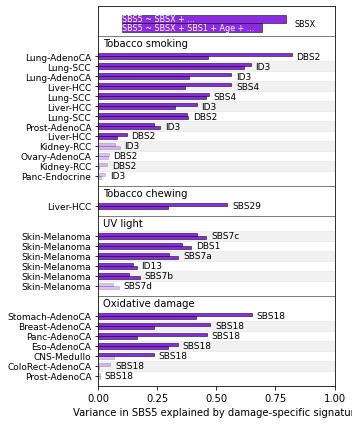

In [13]:
def plot_signatures(eti_order, res_sign, th, ax):

    # Define color mapping
    pal = {"SBS5": "#8A2BE2", "SBS1": "#FFD700"}

    # Plot settings
    ymax, cumul, xmar, fs, bwidth = 1.5, 1, 0.02, 9, 0.3
    yticks, ylabels = [], []
    panel_mar = 2
    y_mar = 0.15

    # Loop over etiologies
    for e in eti_order:
        df = res_sign[res_sign.etiology == e].copy()
        df = df.sort_values("r2_0").reset_index(drop=True)

        for i, r in df.iterrows():
            
            ypos = i + cumul
            if i % 2 != 0:
                rect_height = 1  
                rect_ypos = ypos - 0.5
                ax.add_patch(plt.Rectangle((0, rect_ypos), 1, rect_height, 
                                          color='lightgray', alpha=0.3, zorder=0))

            ax.barh(ypos + y_mar, r.r2_0, height=bwidth, alpha=1 if r.p_0 < th else 0.3,
                    color=pal["SBS5"], edgecolor="black", lw=0.5)
            ax.barh(ypos - y_mar, r.r2_2, height=bwidth, alpha=1 if r.p_2 < th else 0.3,
                    color=pal["SBS5"], edgecolor="black", lw=0.5)
            #ax.barh(ypos, r.SBS1_r2, left=r.SBS5_r2, height=bwidth, 
            #        color=pal["SBS1"], edgecolor="black", lw=0.5)

            mul = 1
            max_r2 = max(r.r2_0, r.r2_2)
            dmg_sig = f"{r.signature}" #if r.p_2 < th else r.signature
#            ax.annotate(f"{dmg_sig} ({int(r.total_dmg_muts/1e3)}k, n={r.n_cancers})", 
            ax.annotate(f"{dmg_sig}", 
                        (max_r2 + xmar * mul, ypos), 
                        va="center", ha="left", fontsize=fs)

#            ax.scatter(0.95, ypos, s=r.remap_muts, color=pal["SBS5"])

            yticks.append(ypos)
            ylabels.append(r.ctype.replace(" (PCAWG)", ""))

        ax.axhline(ypos + panel_mar, color="black", lw=0.5)
        ax.annotate(e, (0.02, ypos + 1))
        cumul += len(df) + panel_mar


    # Add legend
    leg_ax = ax.inset_axes([0.1, 0.93, 0.8, 0.05])  
#    leg_ax = ax.inset_axes([0.4, 0.55, 0.55, 0.05])  
    height,lw = 1, 0.5
    #height,lw = 0.1, 0.5
    leg_ax.barh([1], 0.2, color=pal["SBS5"], edgecolor="black", lw=lw, height=height)
    leg_ax.barh([0], 0.17, color=pal["SBS5"], edgecolor="black", lw=lw, height=height)

    leg_ax.set_xticks([])
    leg_ax.set_yticks([])
    leg_ax.set_xlim([0, 0.23])
    leg_ax.annotate("SBSX", (0.21, 0.5), va="center", ha="left",
                    fontsize=8, color="black")
    leg_ax.annotate("SBS5 ~ SBSX + ...", (0, 1), va="center", ha="left", 
                    fontsize=8, color="white")
    leg_ax.annotate("SBS5 ~ SBSX + SBS1 + Age + ...", (0, 0), va="center", ha="left", 
                    fontsize=8, color="white")
    leg_ax.axis("off")
    
    # Set axes properties
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_ylim(0, cumul - 1 + 3)
    ax.set_xlim(0, 1)
    ax.tick_params(axis="y", labelsize=fs)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_xlabel("Variance in SBS5 explained by damage-specific signature")

# Example usage
fig, ax = plt.subplots(figsize=(5, 6))
plot_signatures(eti_order, res_sign, th, ax)
plt.tight_layout()
#plt.savefig("pdfs/pcawg_cors.pdf")
#plt.savefig("pdfs/jin_cors.pdf")
plt.show()

if type=="jin":
    res_sign.to_csv("jin_results.csv", index=False)
if type=="aov":
    res_sign.to_csv("aov_results.csv", index=False)

In [14]:
dov = pd.read_csv("aov_results.csv")
jin = pd.read_csv("jin_results.csv")

dov = dov.set_index(["signature", "ctype"])
jin = jin.set_index(["signature", "ctype"])

merg = dov.join(jin, lsuffix='_dov', rsuffix='_jin').reset_index()

Non-cancer data

In [15]:
def reform_signet(df):
    """Standardize column names if nSBS columns are present."""
    if sum(c.startswith("nSBS") for c in df.columns) > 10:
        df = df.rename(columns={c: f"f{c}" for c in df.columns if c.startswith("SBS")})
        df = df.rename(columns={c: c[1:] for c in df.columns if c.startswith("nSBS")})
    return df

def filter_min_obs(df, n):
    """Filter individuals with more than n observations."""
    keep = df.groupby("Individual").size()
    return df[df["Individual"].isin(keep[keep > n].index)].copy()


In [16]:
# === Yoshida 2020 ===
yosh = pd.read_csv("../data/Yoshida2020/Yoshida2020-signet.tab", sep="\t")
yosh = reform_signet(yosh).rename(columns={"Samples": "Sample"})

yosh_meta = pd.read_csv("../data/Yoshida2020/Lung_organoids_telomeres_with_contamination_20190408.txt", sep="\t")
yosh = yosh_meta.join(yosh.set_index("Sample"), on="Sample")
yosh["Individual"] = yosh["Sample"].str[:7]
yosh = yosh[yosh["Smoking"] != "non-smoker"]

# === Ng 2021 ===
ng = pd.read_csv("../data/Ng2021/Ng2021-signet.tab", sep="\t")
ng = reform_signet(ng).rename(columns={"Samples": "Sample"})

ng_meta = pd.read_excel(
    "../data/Ng2021/41586_2021_3974_MOESM3_ESMM/Supplementary Table 1.xlsx",
    skiprows=4
).rename(columns={
    "Patient ID": "Individual",
    "Age at \noperation (yrs)": "Age"
})

ng["Individual"] = ng["Sample"].str[:7]
ng["Age"] = ng["Individual"].map(ng_meta.set_index("Individual")["Age"].to_dict())

smokers = ng_meta[~ng_meta["Smoking \nstatus"].isin(["Never"])]["Individual"].unique()
ng = ng[ng["Individual"].isin(smokers)]

# === Olafsson 2023 ===

olaf = pd.read_csv("../data/Olafsson2023/Olafsson2023-signet.tab", sep="\t")
olaf = reform_signet(olaf).rename(columns={"Samples": "Sample"})

patient_meta = pd.read_excel(
    "../data/Olafsson2023/41588_2023_1545_MOESM4_ESM.xlsx",
    sheet_name="TableS1_patient_metadata"
)
biops_meta = pd.read_excel(
    "../data/Olafsson2023/41588_2023_1545_MOESM4_ESM.xlsx",
    sheet_name="TableS2_Microdissection_metadat"
)

olaf["Individual"] = olaf["Sample"].str.split("_").str[0]
patient_meta["Individual"] = patient_meta["Patient.ID"]
olaf = olaf.merge(patient_meta, on="Individual").rename(columns={"Age_at_sampling": "Age"})

olaf["SampleID"] = olaf["Sample"].apply(lambda x: "_".join(x.split("_")[1:]))
olaf = olaf.merge(biops_meta, on="SampleID")

olaf = olaf[~olaf["Sample"].str.contains("WG")]
olaf = olaf[olaf["Shows_Psoralen_signature"] == False]
olaf["SBS7_"] = olaf["SBS7a"] + olaf["SBS7c"] + olaf["SBS7d"]  

# === Olafsson 2020 ===
olaf20 = pd.read_csv("../data/Olafsson2020/Olafsson2020-signet.tab", sep="\t")
olaf20 = reform_signet(olaf20).rename(columns={"Samples": "Sample", "patient_ID": "Individual"})

olaf20_meta = pd.read_csv("../data/Olafsson2020/cell_11495_mmc2.txt", sep="\t")
olaf20_meta["Individual"] = olaf20_meta["patient_ID"]

if "Sample" in olaf20.columns:
    olaf20["Individual"] = olaf20["Sample"].str.split("_").str[0]
    ages = olaf20_meta.set_index("patient_ID")["Age"].to_dict()
    olaf20["Age"] = olaf20["Individual"].map(ages)

# === Wang 2023 ===

wang = pd.read_csv(f"../data/Wang2023/Wang2023.onlyspec-signet.tab", sep="\t")
wang["Individual"] = wang["Sample"].str[:7]
wang = reform_signet(wang)

wang_meta = pd.read_excel(
    "../data/Wang2023/41588_2022_1296_MOESM4_ESM.xlsx",
    sheet_name="4_crypt_summary",
    skiprows=1
)
wang_meta["Individual"] = wang_meta["sample"].str[:7]
wang["Age"] = wang["Individual"].map(wang_meta.set_index("Individual")["age"].to_dict())

# === Combine Olafsson 2020 and Wang 2023 ===
olaf20wang = pd.concat([olaf20])

Olaf 2023

Plot together

In [17]:
def fit_model(df, sign, covars):
    df2 = df.copy()
    df2[[sign] + ["SBS1","SBS5"]] = scaler.fit_transform(df2[[sign] + ["SBS1","SBS5"]])
    mod = smf.ols(f"{sign} ~ SBS1 + SBS5 + " + " + ".join(covars),
                  data=df2).fit()
    anova = anova_lm(mod, typ=2)
    anova['r2'] = anova['sum_sq'] / anova['sum_sq'].sum()
    return mod, anova

def plot_model(df, y, x, ax, **kwargs):

    mod = smf.ols(data=df, formula=f"{y} ~ {x}").fit()
    xs = np.linspace(df[x].min(), df[x].max(), 1000)
    pred_data = {x: xs}
    for covar in mod.model.exog_names:
        if covar != "Intercept" and covar != x:
            pred_data[covar] = df[covar].mean()  
            print(f"Here doing {covar}")

    pred_df = pd.DataFrame(pred_data)
    ys = mod.predict(pred_df)
    ax.plot(xs, ys, **kwargs)
    return mod

def plot_model_and_r2(df, y, x, r2s, p2s, th, ax, annot, **kwargs):

    sns.scatterplot(data=df, x=x, y=y, ax=ax, **kwargs)
    
    mod = smf.ols(data=df, formula=f"{y} ~ {x}").fit()
    xs = np.linspace(0, df[x].max() + df[x].min(), 1000)
    pred_data = {x: xs}
    for covar in mod.model.exog_names:
        if covar != "Intercept" and covar != x:
            pred_data[covar] = df[covar].mean()  
    
    pred_df = pd.DataFrame(pred_data)
    ys = mod.predict(pred_df)
    ax.plot(xs, ys, color=kwargs.get("color"))
    
    if annot is not None:
        pal = {"SBS5": "#8A2BE2", "SBS1": "#FFD700"}
        
        inset_ax = ax.inset_axes([0.1, 0.8, 0.3, 0.1])  # [x, y, width, height] in axes coordinates
        height,lw = 1, 0.5
        inset_ax.barh([1], r2s[0], color=pal["SBS5"], alpha=1 if p2s[0] < th else 0.5,
                      edgecolor="black", lw=lw, height=height)
        inset_ax.barh([0], r2s[1], color=pal["SBS5"], alpha=1 if p2s[1] < th else 0.5,
                      edgecolor="black", lw=lw, height=height)
        #inset_ax.barh([0], r2s[2], color=pal["SBS5"], edgecolor="black", lw=lw, height=height)
        
        inset_ax.set_xlim(0, 1)
        inset_ax.set_yticks([])
        #inset_ax.set_yticklabels(["R²"])
        #inset_ax.tick_params(axis="y", length=0)  # Hide the tick line
        inset_ax.set_ylim([-0.5,1.5])
        inset_ax.set_xticks([0, 0.5, 1])
        inset_ax.set_xticklabels(["0", "", "1"])
        inset_ax.set_xlabel("R²", labelpad=-7)
        #inset_ax.set_title("R²", fontsize=10)

    ax.set_xlabel(f"{x} mutations")
    ax.set_ylabel(f"{y} mutations")

    

def master_func(params, panel, ax):
  
    ind_sig = params["ind_sig"]
    dep_sig = params["dep_sig"]
    data = params["data"]

    # Filters
    data = data[data[ind_sig] > 1].copy()
    if panel in ["B", "C", "D", "E"]:
        data = filter_min_obs(data, 1)      
    params["data"] = data

    # R² values
    r2_0, mod_0 = fit_ols_semipartial_r2(data, dep_sig, [ind_sig])
    r2_2, mod_2 = fit_ols_semipartial_r2(data, dep_sig, [ind_sig] + covars)
    print(r2_0)
    print(r2_2)
    print(calculate_vif(mod_2))
    r2s = [r2_0[ind_sig], r2_2[ind_sig]]
    p2s = [mod_0.pvalues[ind_sig], mod_2.pvalues[ind_sig]]
    datal = [r2_0[ind_sig], 
            mod_0.pvalues[ind_sig], 
            r2_2[ind_sig], 
            mod_2.pvalues[ind_sig]]
    datal.append(ind_sig)
    datal.append(len(data))
    datal.append(params["title"])

    # Plotting
    plot_model_and_r2(
        data, dep_sig, ind_sig, r2s, p2s, 0.05 / 2, ax, (0.1, 0.9),
        color="darkgray",
        s= 20 if panel not in ["B", "C", "D", "E"] else 7 if panel != "C" else 5,
        alpha=0.5 if panel in ["B", "C", "D", "E"] else 0.9
    )

    for indv, df in data.groupby("Individual"):
        pass
#        plot_model(df, dep_sig, ind_sig, ax, color="darkgray", ls="--", lw=0.5)

    # Mixed effects model
                                     #re_formula=f"~{ind_sig}",
    lme_mod = MixedLM.from_formula(f"{dep_sig} ~ {ind_sig} + SBS1",
                                   groups="Individual",
                                   re_formula="1",
                                   data=data).fit(method="powell")
    ax.set_xlim(left=0)
    if panel == "C":
        lim = 250
        ax.set_ylim([0, lim])
        print(len(data[data[dep_sig]>lim]), "ignored datapoints in C")
    else:
        ax.set_ylim(bottom=0)

    if ind_sig=="SBS7_":
        ax.set_xlabel("SBS7a/c/d mutations")

    ax.set_title(params["title"], fontsize=10)
    print(lme_mod.pvalues)
    
#    return lme_mod.pvalues[ind_sig]
    return datal

Yoshida 2020
{'SBS4': 0.7871724676820596}
{'SBS4': 0.5347396406369541, 'Age': 0.012916143640592015, 'SBS1': 0.004855921734406632}
  Variable       VIF
0     SBS4  1.289031
2     SBS1  1.238634
1      Age  1.102124
Intercept          7.065615e-59
SBS4              1.798958e-146
SBS1               8.098347e-03
Individual Var     9.526485e-02
dtype: float64
Olafsson 2023
{'SBS7_': 0.3580942969225347}
{'SBS7_': 0.27704178561326376, 'Age': 0.013114564913797144, 'SBS1': 0.10008803625725882}
  Variable       VIF
0    SBS7_  1.467239
1      Age  1.349053
2     SBS1  1.231127
2 ignored datapoints in C
Intercept         1.706915e-02
SBS7_             2.264395e-99
SBS1              6.549638e-53
Individual Var    8.595147e-06
dtype: float64
Ng 2021
{'SBS4': 0.5353426790839702}
{'SBS4': 0.6386795774209734, 'Age': 0.0002054416454053687, 'SBS1': 0.15119527175574476}
  Variable       VIF
0     SBS4  1.273525
2     SBS1  1.219589
1      Age  1.068069
Intercept          3.962644e-42
SBS4              5.

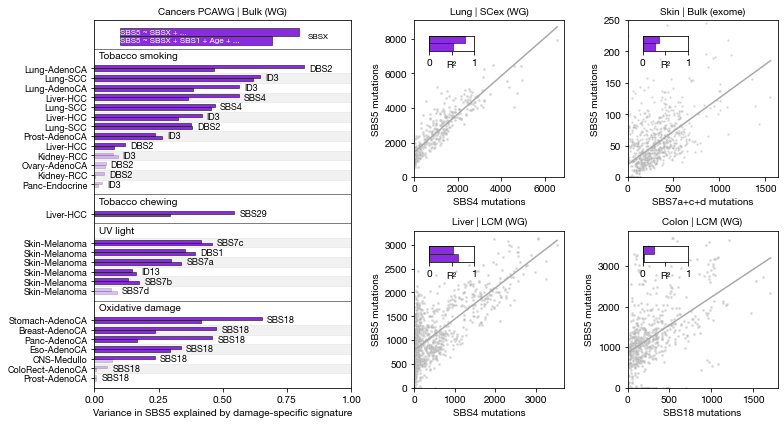

In [19]:
# Configuration
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
AAABBCC
AAADDEE
'''
fig, axs = plt.subplot_mosaic(mosaic, figsize=[11,6])
fs = 9
annot = True
covars = ["Age", "SBS1"]
gvar = "Individual"
dep_sig = "SBS5"

# Define datasets and their parameters in a dictionary
datasets = {
    "A": {
        "function": plot_signatures,
        "args": (eti_order, res_sign),
        "title": "Cancers PCAWG | Bulk (WG)"
    },
    "B": {
        "data": yosh,
        "ind_sig": "SBS4",
        "dep_sig": "SBS5",
        "title": "Lung | SCex (WG)",
        "label": "Yoshida 2020"
    },
    "E": {
        "data": olaf20wang,
        "ind_sig": "SBS18",
        "dep_sig": "SBS5",
        "title": "Colon | LCM (WG)",
        "label": "Olafsson 2020"
    },
    "D": {
        "data": ng,
        "ind_sig": "SBS4",
        "dep_sig": "SBS5",
        "title": "Liver | LCM (WG)",
        "label": "Ng 2021"
    },
    "C": {
        "data": olaf,
        "ind_sig": "SBS7_",
        "dep_sig": "SBS5",
        "title": "Skin | Bulk (exome)",
        "label": "Olafsson 2023"
    }
}

# Special case for panel A
plot_signatures(eti_order, res_sign, th, axs["A"])
axs["A"].set_title(datasets["A"]["title"], fontsize=10)

# Process panels B-E
nonc_params_l = []
for panel in ["B", "C", "D", "E"]:
    params = datasets[panel]
    print(params["label"])
    
    mod_params = master_func(params, panel, axs[panel])
    nonc_params_l.append(mod_params)
axs["C"].set_xlabel("SBS7a+c+d mutations")    

nonc_params = pd.DataFrame(nonc_params_l)
nonc_params.columns = ["r2_0","p_0","r2_2",	"p_2", "signature", "n_samples", "pub"]
nonc_params.to_csv("nonc_results.csv", index=False)

# Final layout and save
plt.tight_layout()
plt.savefig("pdfs/fig3.pdf")
plt.savefig("pdfs/fig3.jpg", dpi=400)

In [190]:
df = datasets["B"]["data"]
fsigs = [s for s in df.columns if "fSBS" in s]
tsigs = [s for s in df.columns if s.startswith("SBS")]
mdf = pd.concat([datasets[p]["data"].set_index("Sample")[tsigs] for p in ["B", "C", "D", "E"]])

In [198]:
mdf[tsigs].sum()>100

SBS1     True
SBS2     True
SBS3     True
SBS4     True
SBS5     True
         ... 
SBS86    True
SBS87    True
SBS88    True
SBS89    True
SBS90    True
Length: 72, dtype: bool

In [19]:
ng2 = ng[ng["SBS4"] > 1].copy()
ng2 = filter_min_obs(ng2, 1)

lme_mod = MixedLM.from_formula(f"SBS5 ~ SBS4 + SBS1",
                                   groups="Individual",
                                   re_formula="1",
                                   data=ng2).fit(method="powell")
lme_mod.pvalues

Intercept          3.962644e-42
SBS4              5.283453e-183
SBS1               1.745910e-47
Individual Var     5.312613e-03
dtype: float64

Supplementary figures

In [42]:
dat = pd.DataFrame()
for corr_file in os.listdir("corr_files/"):
    if corr_file.startswith("SBS18") and corr_file.endswith(".csv"):
        df = pd.read_csv(f"corr_files/{corr_file}")
        dat = pd.concat([dat, df], axis=0)

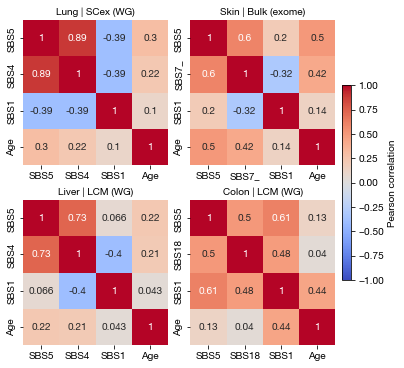

In [48]:
mosaic = '''
BBCC
DDEE
'''

fig, axs = plt.subplot_mosaic(mosaic, figsize=[5.5, 5], constrained_layout=True)

last_hm = None

for panel in ["B", "C", "D", "E"]:
    params = datasets[panel]
    ind_sig = params["ind_sig"]
    data = params["data"]
    ax = axs[panel]

    last_hm = sns.heatmap(data[["SBS5", ind_sig, "SBS1", "Age"]].corr(),
                          annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                          ax=ax, cbar=False)

    ax.set_title(params["title"], fontsize=10)


cbar = fig.colorbar(last_hm.collections[0], ax=list(axs.values()), label="Pearson correlation", shrink=0.6, pad=0.02)
plt.savefig("sup_pdfs/sig_correlations_non-cancer_signet.pdf")
plt.savefig("sup_pdfs/sig_correlations_non-cancer_signet.jpg", dpi=400)

Yoshida 2020
Olafsson 2023
Ng 2021
Olafsson 2020


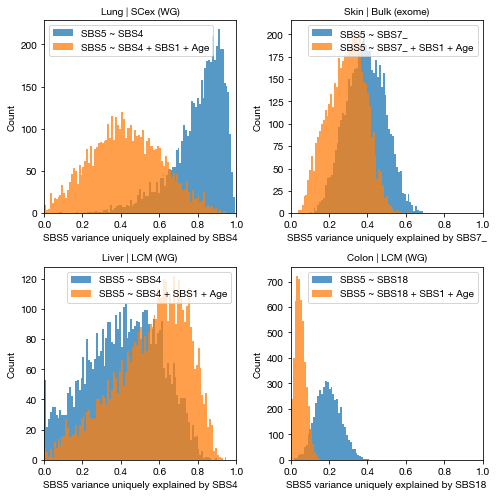

In [ ]:
mosaic = '''
BBCC
DDEE
'''

fig, axs = plt.subplot_mosaic(mosaic, figsize=[7,7])
reps = 5000

for panel in ["B", "C", "D", "E"]:
    params = datasets[panel]
    print(params["label"])
    ind_sig = params["ind_sig"]
    data = params["data"]
    ax = axs[panel]
    
    resamp_l = []
    resamp_r2_l = []
    for r in range(reps):
        sdf = data.groupby("Individual").apply(lambda df: df.sample(1))
        sdf["rep"] = r
        resamp_l.append(sdf)
        r2_1, mod_1 = fit_ols_semipartial_r2(sdf, "SBS5", [ind_sig])
        r2_2, mod_2 = fit_ols_semipartial_r2(sdf, "SBS5", [ind_sig, "SBS1", "Age"])
        resamp_r2_l.append([r2_1[ind_sig], r2_2[ind_sig], r])
    resamp_yosh = pd.concat(resamp_l)
    resamp_r2 = pd.DataFrame(resamp_r2_l)
    resamp_r2.columns = ["r2_1", "r2_2", "rep"]

    sns.histplot(data=resamp_r2, x="r2_1", binwidth=0.01, 
                 label=f"SBS5 ~ {ind_sig}", 
                 edgecolor="none", ax=ax)
    sns.histplot(data=resamp_r2, x="r2_2", binwidth=0.01, 
                 label=f"SBS5 ~ {ind_sig} + SBS1 + Age", 
                 edgecolor="none",ax=ax)
    ax.legend()
    ax.set_title(params["title"], fontsize=10)
    ax.set_xlim(left=[0,1])
    ax.set_xlabel(f"SBS5 variance uniquely explained by {ind_sig}")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.savefig("sup_pdfs/resamp-cells.pdf")
plt.savefig("sup_pdfs/resamp-cells.jpg", dpi=400)

Saini 2021

In [52]:
saini = pd.read_excel("../data/Saini2021/journal.pgen.1009302.s012.xlsx", sheet_name="S3b")
meta_saini = pd.read_excel("../data/Saini2021/journal.pgen.1009302.s010.xlsx", sheet_name="S1 Table", skiprows=3)
ages = meta_saini.set_index("Sample Name")["Age"].to_dict()
donors = meta_saini.set_index("Sample Name")["Donor"].to_dict()
saini["Age"] = saini["Samples"].map(ages)
saini["Donor"] = saini["Samples"].map(donors)
saini["Individual"] = saini["Donor"]
saini["SBS7b_DBS1"] = saini["SBS7b"] + saini["DBS1"]

Intercept    0.053689
SBS7b        0.000175
SBS1         0.715422
Age          0.025260
dtype: float64 {'SBS7b': 0.2394966469498987, 'SBS1': 0.0018461397613269703, 'Age': 0.07451494407440051}
Intercept    0.039892
DBS1         0.000037
SBS1         0.686870
Age          0.019781
dtype: float64 {'DBS1': 0.2786661952488194, 'SBS1': 0.002078131965731811, 'Age': 0.07486694923080517}


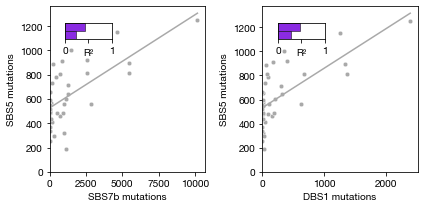

In [63]:
f,axs = plt.subplots(1,2, figsize=(6, 3))
dep_sig = "SBS5"
#ind_sig = "SBS7b_DBS1"
covars = ["SBS1", "Age"]
ind_sigs = ["SBS7b", "DBS1"]

for i,ax in enumerate(axs):
    ind_sig = ind_sigs[i]
    r2_0, mod_0 = fit_ols_semipartial_r2(saini, dep_sig, [ind_sig])
    r2_2, mod_2 = fit_ols_semipartial_r2(saini, dep_sig, [ind_sig] + covars)
    print(mod_2.pvalues, r2_2)
    r2s = [r2_0[ind_sig], r2_2[ind_sig]]
    p2s = [mod_0.pvalues[ind_sig], mod_2.pvalues[ind_sig]]

    # Plot data
    plot_model_and_r2(saini, dep_sig, ind_sig, r2s, p2s, 0.05/2, ax, (0.1, 0.9), 
                        color="darkgray", s=20) # style="Individual",
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

plt.tight_layout()
#plt.savefig("pdfs/saini2021_sbs7b-dbs1.pdf")
#plt.savefig("pdfs/saini2021_sbs7b-dbs1.jpg", dpi=400)

King et al 2023

In [64]:
king = pd.read_excel("../data/King2023/41588_2023_1468_MOESM3_ESM.xlsx", sheet_name="Supp Table 3", skiprows=2)
king["SBS7_"] = king["SBS7a"] + king["SBS7b"] + king["SBS7c"] + king["SBS7d"]

meta = pd.read_csv("../data/King2023/donor_ages_and_area.csv")
ages = meta.set_index("Donor")["Age"].to_dict()
king["interval_Age"] = king.Donor.map(ages)
king = king.dropna().copy()
king["Age"] = [np.mean(list(map(int, a.split("–")))) for a in king["interval_Age"]]
king["Individual"] = king.Donor

Saini 2021
{'SBS7b': 0.40737638134499743}
{'SBS7b': 0.19775996520296568, 'Age': 0.0653594977702241, 'SBS1': 0.010912175655403922}
  Variable       VIF
2     SBS1  1.712556
0    SBS7b  1.573935
1      Age  1.141639
Intercept         2.801457e-10
SBS7b             6.842439e-04
SBS1              8.863637e-01
Individual Var    2.165269e-01
dtype: float64
Saini 2021
{'DBS1': 0.4590327039849037}
{'DBS1': 0.25415677001625003, 'Age': 0.05726762462136337, 'SBS1': 0.005366107120377217}
  Variable       VIF
2     SBS1  1.579668
0     DBS1  1.503533
1      Age  1.092196
Intercept         1.277153e-12
DBS1              4.267037e-05
SBS1              8.679233e-01
Individual Var    1.900024e-01
dtype: float64
King X
{'SBS7_': 0.7883691121947842}
{'SBS7_': 0.06943926891713947, 'Age': 0.00954077076440607, 'SBS1': 0.01083250814186365}
  Variable       VIF
2     SBS1  6.035802
0    SBS7_  5.663698
1      Age  1.175867
Intercept         0.026058
SBS7_             0.103907
SBS1              0.376912
Indivi

/Users/marc/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


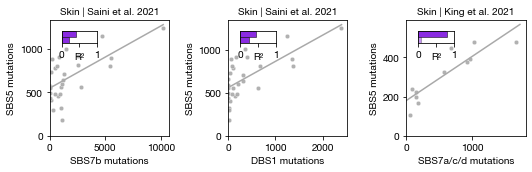

In [77]:
# Configuration
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
KLM
'''
fig, axs = plt.subplot_mosaic(mosaic, figsize=[7.5,2.5])
fs = 9
annot = True
covars = ["Age", "SBS1"]
gvar = "Individual"
dep_sig = "SBS5"

# Define datasets and their parameters in a dictionary
datasets = {
    "K": {
        "data": saini,
        "ind_sig": "SBS7b",
        "dep_sig": "SBS5",
        "title": "Skin | Saini et al. 2021",
        "label": "Saini 2021"
    },
    "L": {
        "data": saini,
        "ind_sig": "DBS1",
        "dep_sig": "SBS5",
        "title": "Skin | Saini et al. 2021",
        "label": "Saini 2021"
    },
    "M": {
        "data": king,
        "ind_sig": "SBS7_",
        "dep_sig": "SBS5",
        "title": "Skin | King et al. 2021",
        "label": "King X"
    }
}


# Process panels B-E
nonc_params_l = []
for panel in datasets.keys():
    params = datasets[panel]
    print(params["label"])
    
    mod_params = master_func(params, panel, axs[panel])
    nonc_params_l.append(mod_params)    

nonc_params = pd.DataFrame(nonc_params_l)
nonc_params.columns = ["r2_0","p_0","r2_2",	"p_2", "signature", "n_samples", "pub"]
nonc_params.to_csv("extra_skin_results.csv", index=False)

# Final layout and save
plt.tight_layout()
plt.savefig("sup_pdfs/extra_skin.pdf")
plt.savefig("sup_pdfs/extra_skin.jpg", dpi=400)

Olafsson 2023

{'SBS7_': 0.3226853485967157}
{'SBS7_': 0.23965371298687432, 'Age': 0.023167296217837974, 'SBS1': 0.08866368846361528}
  Variable       VIF
0    SBS7_  1.450432
1      Age  1.341953
2     SBS1  1.220797
Intercept         5.593353e-09
SBS7_             3.810260e-78
SBS1              6.017462e-47
Individual Var    3.064991e-06
dtype: float64


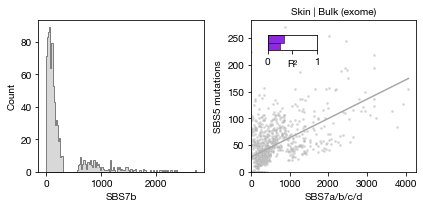

In [83]:
olaf["SBS7_"] = olaf["SBS7a"] + olaf["SBS7c"] + olaf["SBS7d"] + olaf["SBS7b"]

params = {
        "data": olaf,
        "ind_sig": "SBS7_",
        "dep_sig": "SBS5",
        "title": "Skin | Bulk (exome)",
        "label": "Olafsson 2023"
    }

f,axs = plt.subplots(1,2,figsize=[6,3])

# Scatter
master_func(params, "B", axs[1])
axs[1].set_xlabel("SBS7a/b/c/d")

# Distribution of SBS7s
ax = axs[0]
sns.histplot(data=params["data"], x="SBS7b", binwidth=20, element="step", color="gray", 
             ax=ax, alpha=0.3)

plt.tight_layout()
plt.savefig("sup_pdfs/olafsson2023_sbs7b.pdf")
plt.savefig("sup_pdfs/olafsson2023_sbs7b.jpg", dpi=400)

Double check method

Signet

In [98]:
sigpr = "SigProfilerAssignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt"

# === Yoshida 2020 ===

yosh = pd.read_csv(f"../data/Yoshida2020/{sigpr}", sep="\t")
yosh = reform_signet(yosh).rename(columns={"Samples": "Sample"})

yosh_meta = pd.read_csv("../data/Yoshida2020/Lung_organoids_telomeres_with_contamination_20190408.txt", sep="\t")
yosh = yosh_meta.join(yosh.set_index("Sample"), on="Sample")
yosh["Individual"] = yosh["Sample"].str[:7]
yosh = yosh[yosh["Smoking"] != "non-smoker"]

# === Ng 2021 ===

ng = pd.read_csv(f"../data/Ng2021/{sigpr}", sep="\t")
ng = reform_signet(ng).rename(columns={"Samples": "Sample"})

ng_meta = pd.read_excel(
    "../data/Ng2021/41586_2021_3974_MOESM3_ESMM/Supplementary Table 1.xlsx",
    skiprows=4
).rename(columns={
    "Patient ID": "Individual",
    "Age at \noperation (yrs)": "Age"
})

ng["Individual"] = ng["Sample"].str[:7]
ng["Age"] = ng["Individual"].map(ng_meta.set_index("Individual")["Age"].to_dict())

smokers = ng_meta[~ng_meta["Smoking \nstatus"].isin(["Never"])]["Individual"].unique()
ng = ng[ng["Individual"].isin(smokers)]

# === Olafsson 2020 ===

olaf20 = pd.read_csv(f"../data/Olafsson2020/{sigpr}", sep="\t")
olaf20 = reform_signet(olaf20).rename(columns={"Samples": "Sample", "patient_ID": "Individual"})

olaf20_meta = pd.read_csv("../data/Olafsson2020/cell_11495_mmc2.txt", sep="\t")
olaf20["Individual"] = olaf20["Sample"].str.split("_").str[0]
olaf20_meta["Individual"] = olaf20_meta["patient_ID"]

olaf20["Age"] = olaf20["Individual"].map(olaf20_meta.set_index("patient_ID")["Age"].to_dict())
ibd_cohort = olaf20_meta[olaf20_meta["cohort"] == "ibd_cohort"]["patient_ID"].unique()

# === Wang 2023 ===

wang = pd.read_csv(f"../data/Wang2023/{sigpr}", sep="\t")
wang["Individual"] = wang["Samples"].str[:7]

wang_meta = pd.read_excel(
    "../data/Wang2023/41588_2022_1296_MOESM4_ESM.xlsx",
    sheet_name="4_crypt_summary",
    skiprows=1
)
wang_meta["Individual"] = wang_meta["sample"].str[:7]
wang["Age"] = wang["Individual"].map(wang_meta.set_index("Individual")["age"].to_dict())

# === Combine Olafsson 2020 and Wang 2023 ===

#olaf20wang = pd.concat([olaf20, wang])
olaf20wang = olaf20

Yoshida 2020
{'SBS4': 0.7038568986120264}
{'SBS4': 0.5043682466079031, 'Age': 0.030658284774100708, 'SBS1': 0.06811269021188893}
  Variable       VIF
1      Age  1.279856
2     SBS1  1.201063
0     SBS4  1.132855
Intercept         2.539449e-33
SBS4              3.092140e-67
SBS1              1.388725e-23
Individual Var    9.778601e-02
dtype: float64
Ng 2021
{'SBS4': 0.7702487646650503}
{'SBS4': 0.7028601210558192, 'Age': 0.005518395220101779, 'SBS1': 0.02404675666774836}
  Variable       VIF
1      Age  1.063972
0     SBS4  1.057140
2     SBS1  1.006683
Intercept          7.702516e-06
SBS4              6.678680e-222
SBS1               9.003952e-35
Individual Var     1.504270e-02
dtype: float64
Olafsson 2020
{'SBS18': 0.5845987483408388}
{'SBS18': 0.04040628632432541, 'Age': 0.0012676423700299644, 'SBS1': 0.06349336649737913}
  Variable       VIF
2     SBS1  3.953098
0    SBS18  3.284307
1      Age  1.382956
Intercept         1.052422e-05
SBS18             3.502875e-14
SBS1             

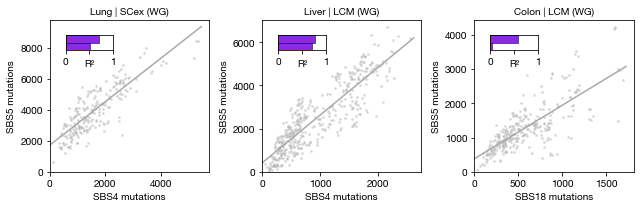

In [99]:
# Configuration
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
EBD
'''
fig, axs = plt.subplot_mosaic(mosaic, figsize=[9,3])
fs = 9
annot = True
covars = ["Age", "SBS1"]
gvar = "Individual"
dep_sig = "SBS5"

# Define datasets and their parameters in a dictionary
datasets = {
    "E": {
        "data": yosh,
        "ind_sig": "SBS4",
        "dep_sig": "SBS5",
        "title": "Lung | SCex (WG)",
        "label": "Yoshida 2020"
    },
    "D": {
        "data": olaf20wang,
        "ind_sig": "SBS18",
        "dep_sig": "SBS5",
        "title": "Colon | LCM (WG)",
        "label": "Olafsson 2020"
    },
    "B": {
        "data": ng,
        "ind_sig": "SBS4",
        "dep_sig": "SBS5",
        "title": "Liver | LCM (WG)",
        "label": "Ng 2021"
    },
}

# Process panels B-E
nonc_params_l = []
for panel in ["E", "B", "D"]:
    params = datasets[panel]
    print(params["label"])
    
    mod_params = master_func(params, panel, axs[panel])
    nonc_params_l.append(mod_params)    

nonc_params = pd.DataFrame(nonc_params_l)
nonc_params.columns = ["r2_0","p_0","r2_2",	"p_2", "signature", "n_samples", "pub"]
nonc_params.to_csv("sigprofiler_results.csv", index=False)

# Final layout and save
plt.tight_layout()
plt.savefig("sup_pdfs/noncancer_sigprofiler.pdf")
plt.savefig("sup_pdfs/noncancer_sigprofiler", dpi=400)

Original in study

In [150]:
# === Yoshida 2020 ===
yosh = pd.read_excel('../data/Yoshida2020/Fig2a.xlsx')
yosh_meta = pd.read_csv("../data/Yoshida2020/Lung_organoids_telomeres_with_contamination_20190408.txt", sep="\t")
yosh = yosh_meta.join(yosh.set_index("Sample"), on="Sample")
yosh["Individual"] = yosh["Sample"].str[:7]
yosh = yosh[yosh["Smoking"] != "non-smoker"]

# === Ng 2021 ===
ng = pd.read_csv("../data/Ng2021/mutsigs_branches.csv.gz")
ng["SBS5"] = ng["Signature P5"] + ng["Signature N2"] # as specified in the Telomeres.html of the Supp Code of Ng 2021
ng["SBS4"] = ng["Signature P4"]
ng["SBS1"] = ng["Signature P1"]
ng["Individual"] = ng["Unnamed: 0"].str[:7]

ng_meta = pd.read_excel(
    "../data/Ng2021/41586_2021_3974_MOESM3_ESMM/Supplementary Table 1.xlsx",
    skiprows=4
).rename(columns={
    "Patient ID": "Individual",
    "Age at \noperation (yrs)": "Age"
})

ng["Age"] = ng["Individual"].map(ng_meta.set_index("Individual")["Age"].to_dict())

# === Olafsson 2020 ===
olaf20 = pd.read_csv("../data/Olafsson2020/cell_11495_mmc2.txt", sep="\t")
olaf20["Individual"] = olaf20.patient_ID

# === Wang 2023 ===
wang = pd.read_excel("../data/Wang2023/41588_2022_1296_MOESM4_ESM.xlsx", 
                     sheet_name="4_crypt_summary", skiprows=1)
wang["Individual"] = wang["sample"].str[:7]
wang.rename(columns = {"age":"Age"})

# === Combine Olafsson 2020 and Wang 2023 ===
olaf20wang = pd.concat([olaf20])

Yoshida 2020
{'SBS4': 0.8789504096392932}
{'SBS4': 0.7822219657746183, 'Age': 0.013833232934907014, 'SBS1': 0.0008641463510616898}
  Variable       VIF
1      Age  1.321014
2     SBS1  1.281785
0     SBS4  1.061588
Intercept         2.791508e-55
SBS4              0.000000e+00
SBS1              1.713720e-01
Individual Var    8.326484e-02
dtype: float64
Ng 2021
{'SBS4': 0.3087959136924021}
{'SBS4': 0.3107866244326367, 'Age': 0.004845128020439793, 'SBS1': 0.020009104166795577}
  Variable       VIF
1      Age  1.007646
2     SBS1  1.007532
0     SBS4  1.002505
Intercept         2.164785e-19
SBS4              2.522424e-70
SBS1              1.037476e-05
Individual Var    1.706685e-03
dtype: float64
Olafsson 2020
{'SBS18': 0.7456687208459469}
{'SBS18': 0.0571616723564764, 'Age': 0.001026348668587973, 'SBS1': 0.052589659982057}
  Variable       VIF
2     SBS1  4.560156
0    SBS18  3.736786
1      Age  1.445793
Intercept         1.876725e-05
SBS18             2.907021e-45
SBS1              3.93

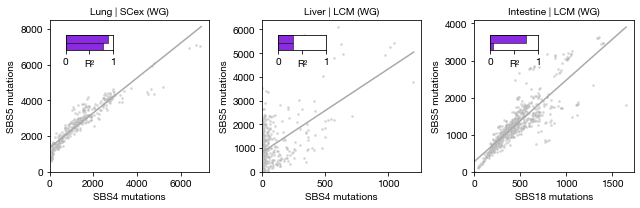

In [151]:
# Configuration
plt.rcParams["font.family"] = "Helvetica Neue"
mosaic = '''
EBD
'''
fig, axs = plt.subplot_mosaic(mosaic, figsize=[9,3])
fs = 9
annot = True
covars = ["Age", "SBS1"]
gvar = "Individual"
dep_sig = "SBS5"

# Define datasets and their parameters in a dictionary
datasets = {
    "E": {
        "data": yosh,
        "ind_sig": "SBS4",
        "dep_sig": "SBS5",
        "title": "Lung | SCex (WG)",
        "label": "Yoshida 2020"
    },
    "D": {
        "data": olaf20wang,
        "ind_sig": "SBS18",
        "dep_sig": "SBS5",
        "title": "Intestine | LCM (WG)",
        "label": "Olafsson 2020"
    },
    "B": {
        "data": ng,
        "ind_sig": "SBS4",
        "dep_sig": "SBS5",
        "title": "Liver | LCM (WG)",
        "label": "Ng 2021"
    },
}

nonc_params_l = []
# Process panels B-E
for panel in ["E", "B", "D"]:
    params = datasets[panel]
    print(params["label"])
    
    mod_params = master_func(params, panel, axs[panel])
    nonc_params_l.append(mod_params)    

nonc_params = pd.DataFrame(nonc_params_l)
nonc_params.columns = ["r2_0","p_0","r2_2",	"p_2", "signature", "n_samples", "pub"]
nonc_params.to_csv("originalsig_results.csv", index=False)

plt.tight_layout()
# Final layout and save
plt.tight_layout()
plt.savefig("sup_pdfs/noncancer_original.pdf")
plt.savefig("sup_pdfs/noncancer_original", dpi=400)

Wang et al 2023

In [152]:
wang["Individual"] = wang["sample"].str[:8]

{'SBS18': 0.5424158348555568}
{'SBS18': 0.005117651316167038, 'Age': 0.12183842850353244, 'SBS1': 0.025157658768694136}
  Variable       VIF
2     SBS1  4.980228
0    SBS18  3.116380
1      Age  2.461533
Intercept         7.229757e-19
SBS18             1.487411e-04
SBS1              2.959972e-34
Individual Var    4.471302e-05
dtype: float64


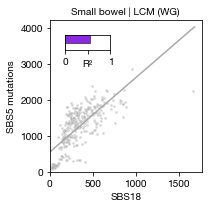

In [153]:
wang = pd.read_excel("../data/Wang2023/41588_2022_1296_MOESM4_ESM.xlsx", sheet_name="4_crypt_summary", skiprows=1)
wang["Individual"] = wang["sample"].str[:8]
wang["Age"] = wang.age

params = {
        "data": wang,
        "ind_sig": "SBS18",
        "dep_sig": "SBS5",
        "title": "Small bowel | LCM (WG)",
        "label": "Wang 2023"
    }

f,ax = plt.subplots(figsize=[3,3])

# Scatter
master_func(params, "B", ax)
ax.set_xlabel("SBS18")

plt.tight_layout()
plt.savefig("sup_pdfs/wang2023_sbs18.jpg", dpi=400)
plt.savefig("sup_pdfs/wang2023_sbs18.pdf")